In [1]:
import os
from functools import partial
import cv2
from PIL import Image
from torchvision import transforms as trans
from torchvision.datasets import DatasetFolder
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from os.path import join as path_join
import tqdm
import matplotlib.pylab as plt
import matplotlib
import torch
%matplotlib inline

In [2]:
roi_dir_name = 'data/ROI_file'
mam_dir_name = 'data/image_file'
crop_dir_name = 'data/crop_data'

num_workers = 1
batch_size = 126
roi_sampling_ratio = .9
n_patches = 25
patch_size = 224
og_resize = (1152, 896)

csv_dir = 'csv_files'
train_table = pd.concat([pd.read_csv(os.path.join(csv_dir, x)) for x in
                             os.listdir(csv_dir) if 'train' in x], sort=False, axis=0).sample(frac=1)
test_table = pd.concat([pd.read_csv(os.path.join(csv_dir, x)) for x in
                             os.listdir(csv_dir) if 'test' in x], sort=False, axis=0).sample(frac=1)

src_transform = trans.Compose([
    Image.fromarray,
    trans.Resize(og_resize),
    trans.Pad(patch_size//2)
])

class RightAngleTransform:
    """Rotate by one of the given angles."""
    def __init__(self):
        self.angles = [0 ,90, 180, 270]
    def __call__(self, x):
        angle = np.random.choice(self.angles)
        return trans.functional.rotate(x, angle)

patch_transform = trans.Compose([
    trans.RandomHorizontalFlip(),
    trans.RandomVerticalFlip(),
    RightAngleTransform(),
    trans.ToTensor()
])

src_batch_size = max(batch_size // n_patches, 1)
dloader_args = {
    'batch_size': batch_size,
    'pin_memory': True,
    'num_workers': num_workers,
    'drop_last': False,
    'shuffle': True
}
grey_loader = partial(cv2.imread, flags=cv2.IMREAD_GRAYSCALE)

In [1216]:
row = train_table.loc[1222].iloc[0]

In [3]:
row = train_table.iloc[1]

In [4]:
mode = 'train'
roi_col = 'ROI mask file path' + ' png'
mam_col = 'image file path' + ' png'
mam_image = src_transform(grey_loader(path_join(mam_dir_name, mode, str(row['label']), row[mam_col])))
roi_image = src_transform(grey_loader(path_join(roi_dir_name, mode, str(row['label']), row[roi_col])))

In [5]:
def crop_val(v, minv, maxv):
    v = v if v >= minv else minv
    v = v if v <= maxv else maxv
    return v

In [6]:
def overlap_patch_roi(patch_center, patch_size, roi_mask, 
                      add_val=500, cutoff=.5):
    x1,y1 = (patch_center[0] - patch_size//2, 
             patch_center[1] - patch_size//2)
    x2,y2 = (patch_center[0] + patch_size//2, 
             patch_center[1] + patch_size//2)
    x1 = crop_val(x1, 0, roi_mask.shape[1])
    y1 = crop_val(y1, 0, roi_mask.shape[0])
    x2 = crop_val(x2, 0, roi_mask.shape[1])
    y2 = crop_val(y2, 0, roi_mask.shape[0])
    roi_area = (roi_mask>0).sum()
    roi_patch_added = roi_mask.astype('uint16').copy()
    roi_patch_added[y1:y2, x1:x2] += add_val
    patch_area = (roi_patch_added>=add_val).sum()
    inter_area = (roi_patch_added>add_val).sum().astype('float32')
    return (inter_area/roi_area > cutoff or inter_area/patch_area > cutoff)

In [7]:
def add_img_margins(img, margin_size):
    '''Add all zero margins to an image
    '''
    enlarged_img = np.zeros((img.shape[0]+margin_size*2, 
                             img.shape[1]+margin_size*2), dtype=img.dtype)
    enlarged_img[margin_size:margin_size+img.shape[0], 
                 margin_size:margin_size+img.shape[1]] = img
    return enlarged_img

In [8]:
def sample_patches_redu(img, roi_mask, 
                   patch_size=244, pos_cutoff=.75, neg_cutoff=.35,
                   nb_bkg=100, nb_abn=100, start_sample_nb=0,
                   seed=12345):
    patches = []   
    targets = []
    img = add_img_margins(img, patch_size//2)
    roi_mask = add_img_margins(roi_mask, patch_size//2)

    # Get ROI bounding box.
    roi_mask_8u = roi_mask.astype('uint8')
    _,contours,_ = cv2.findContours(roi_mask_8u.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cont_areas = [ cv2.contourArea(cont) for cont in contours ]
    idx = np.argmax(cont_areas)  # find the largest contour.
    rx,ry,rw,rh = cv2.boundingRect(contours[idx])
    
    rng = np.random.RandomState(seed)
    # Sample abnormality first.
    sampled_abn = 0
    nb_try = 0
    while sampled_abn < nb_abn:
        x = rng.randint(rx, rx + rw)
        y = rng.randint(ry, ry + rh)
        nb_try += 1
        if nb_try >= 1000:
            #"Nb of trials reached maximum, decrease overlap cutoff by 0.05"
            sys.stdout.flush()
            pos_cutoff -= .05
            nb_try = 0
            if pos_cutoff <= .0:
                raise Exception("overlap cutoff becomes non-positive, "
                                "check roi mask input.")
        # import pdb; pdb.set_trace()
        if overlap_patch_roi((x,y), patch_size, roi_mask, cutoff=pos_cutoff):
            patch = img[y - patch_size//2:y + patch_size//2, 
                        x - patch_size//2:x + patch_size//2]
            patches.append(patch)
            targets.append((x,y))
            sampled_abn += 1
            nb_try = 0
    
    # Sample background.
    sampled_bkg = start_sample_nb
    while sampled_bkg < start_sample_nb + nb_bkg:
        x = rng.randint(patch_size//2, img.shape[1] - patch_size//2)
        y = rng.randint(patch_size//2, img.shape[0] - patch_size//2)
        if not overlap_patch_roi((x,y), patch_size, roi_mask, cutoff=neg_cutoff):
            patch = img[y - patch_size//2:y + patch_size//2, 
                        x - patch_size//2:x + patch_size//2]
            patches.append(patch)
            targets.append((x,y))
            sampled_bkg += 1
            
    return patches, targets

In [9]:
def q_sample_patches(img, roi_image, 
                   patch_size=244, pos_cutoff=.75, neg_cutoff=.35,
                   nb_bkg=100, nb_abn=100, start_sample_nb=0,
                   seed=12345):

    rng = np.random.RandomState(seed)
    roi_f = (np.array(roi_image)>0).astype(float)
    roi_size = roi_f.sum()
    patch_cover = cv2.blur(roi_f, (patch_size,patch_size))
    roi_cover = (patch_cover * (patch_size**2)) / roi_size
    
    # edge case - might be less then thresh
    image_thresh = max(patch_cover.max(), roi_cover.max())
    pos_cutoff = image_thresh * .95 if image_thresh < pos_cutoff else pos_cutoff
    
    # abnormalities
    abn_filter = (patch_cover > pos_cutoff) | (roi_cover > pos_cutoff)
    abn_targets = np.argwhere(abn_filter)
    # force center in image and sample
    abn_targets = abn_targets[(abn_targets[:,0] + (patch_size//2) < roi_f.shape[0]) &
                              (abn_targets[:,0] - (patch_size//2) > 0) &
                              (abn_targets[:,1] + (patch_size//2) < roi_f.shape[1]) &
                              (abn_targets[:,1] - (patch_size//2) > 0)]
    abn_targets = abn_targets[rng.choice(len(abn_targets), nb_abn)]
    
    # background
    bkg_filter = (patch_cover < neg_cutoff) & (roi_cover < neg_cutoff)
    bkg_targets = np.argwhere(bkg_filter)
    # force center in image and sample
    bkg_targets = bkg_targets[(bkg_targets[:,0] + (patch_size//2) < roi_f.shape[0]) &
                              (bkg_targets[:,0] - (patch_size//2) > 0) &
                              (bkg_targets[:,1] + (patch_size//2) < roi_f.shape[1]) &
                              (bkg_targets[:,1] - (patch_size//2) > 0)]
    bkg_targets = bkg_targets[rng.choice(len(bkg_targets), nb_bkg)]
    
    patches = []
    rng = np.random.RandomState(seed)
    targets = np.concatenate([abn_targets, bkg_targets])
    for target_x, target_y in targets:
        patch = img.crop((target_y - patch_size//2, target_x - patch_size//2, 
                          target_y + patch_size//2, target_x + patch_size//2))
        patches.append(patch_transform(patch))
    return patches, targets

In [1018]:
%timeit patches, targets = sample_patches_redu(mam_image, roi_image, nb_abn=10, nb_bkg=10, pos_cutoff=.9)

KeyboardInterrupt: 

In [1032]:
%timeit patches, targets = q_sample_patches(mam_image, roi_image, nb_bkg=100, nb_abn=100, pos_cutoff=.9, neg_cutoff=.1)

81.1 ms ± 415 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


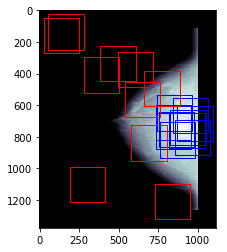

In [10]:
n_samp = 10
patches, targets = q_sample_patches(mam_image, roi_image, nb_bkg=n_samp, nb_abn=n_samp, pos_cutoff=.9, neg_cutoff=.35, seed=np.random.randint(1000))
plt.close()
ax = plt.imshow(np.array(mam_image), cmap='bone')
for i,target in enumerate(targets):
    x,y = target
    ax.axes.add_patch(plt.Rectangle((y-patch_size//2, x-patch_size//2), patch_size, patch_size, 
                                    linewidth=1,edgecolor='b' if i<n_samp else 'r',facecolor='none', alpha=1))

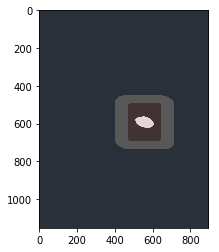

In [867]:
plt.imshow(np.array(roi_image), cmap='bone', alpha=1)
plt.imshow(abn_filter, alpha=.2, cmap='Reds')
plt.imshow(bkg_filter, alpha=.2, cmap='Blues')

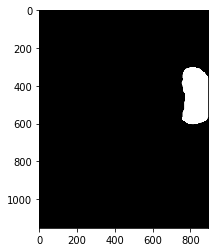

In [1238]:
plt.imshow(roi_image)

In [1239]:
rng = np.random.RandomState(0)
roi_f = (np.array(roi_image)>0).astype(float)
roi_size = roi_f.sum()
patch_cover = cv2.blur(roi_f, (patch_size,patch_size))
roi_cover = (patch_cover * (patch_size**2)) / roi_size

# abnormalities
abn_filter = (patch_cover > pos_cutoff) | (roi_cover > pos_cutoff)
abn_targets = np.argwhere(abn_filter)


In [1240]:
patch_cover.max(), roi_cover.max()

(0.9932637117346937, 1.309046018071023)

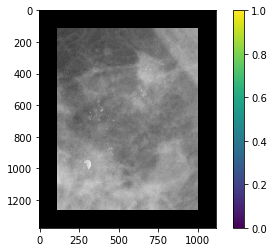

In [17]:
plt.imshow(roi_image, vmin=0, vmax=1)
plt.colorbar()

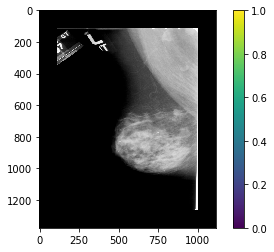

In [15]:
plt.imshow(mam_image, vmin=0, vmax=1)
plt.colorbar()

In [1214]:
patch_cover

array([[0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.]])

In [28]:
n_samp = 10
mode = 'test'
for i, (og_i, row) in tqdm.tqdm_notebook(enumerate(test_table.iterrows()), total=len(test_table)):
    mam_image = src_transform(grey_loader(path_join(mam_dir_name, mode, str(row['label']), row[mam_col])))
    roi_image = src_transform(grey_loader(path_join(roi_dir_name, mode, str(row['label']), row[roi_col])))
    try:
        patches, targets = q_sample_patches(mam_image, roi_image, nb_bkg=n_samp, nb_abn=n_samp, pos_cutoff=.9, neg_cutoff=.1)
    except:
        print(i, row[roi_col], row[mam_col])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


276 Calc-Test_P_01483_LEFT_MLO_1.png Calc-Test_P_01483_LEFT_MLO.png
333 Calc-Test_P_02418_RIGHT_MLO_1.png Calc-Test_P_02418_RIGHT_MLO.png
418 Calc-Test_P_00299_RIGHT_CC_1.png Calc-Test_P_00299_RIGHT_CC.png
514 Calc-Test_P_01883_RIGHT_MLO_1.png Calc-Test_P_01883_RIGHT_MLO.png
584 Calc-Test_P_00811_LEFT_CC_1.png Calc-Test_P_00811_LEFT_CC.png
680 Calc-Test_P_00299_RIGHT_MLO_1.png Calc-Test_P_00299_RIGHT_MLO.png



In [59]:
n_samp = 10
mode = 'train'
for i, (og_i, row) in tqdm.tqdm_notebook(enumerate(train_table.iterrows()), total=len(train_table)):
    if i>2555: break
    mam_image = src_transform(grey_loader(path_join(mam_dir_name, mode, str(row['label']), row[mam_col])))
    roi_image = src_transform(grey_loader(path_join(roi_dir_name, mode, str(row['label']), row[roi_col])))
    try:
        patches, targets = q_sample_patches(mam_image, roi_image, nb_bkg=n_samp, nb_abn=n_samp, pos_cutoff=.9, neg_cutoff=.1)
    except:
        print(i, row[roi_col], row[mam_col])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


2555 Calc-Training_P_00474_LEFT_MLO_1.png Calc-Training_P_00474_LEFT_MLO.png



In [30]:
train_prob = ['Calc-Training_P_00474_LEFT_MLO_1.png']

In [45]:
test_prob = ['Calc-Test_P_01483_LEFT_MLO_1.png', 'Calc-Test_P_02418_RIGHT_MLO_1.png', 'Calc-Test_P_00299_RIGHT_CC_1.png', 
'Calc-Test_P_01883_RIGHT_MLO_1.png', 'Calc-Test_P_00811_LEFT_CC_1.png', 'Calc-Test_P_00299_RIGHT_MLO_1.png']

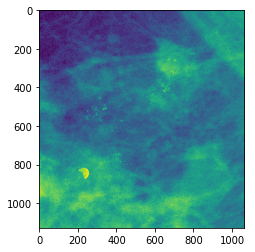

In [51]:
row = train_table[train_table[roi_col] == 'Calc-Training_P_00474_LEFT_MLO_1.png'].iloc[0]
roi_image = (grey_loader(path_join(roi_dir_name, 'train', str(row['label']), row[roi_col])))
plt.figure()
plt.imshow(roi_image)

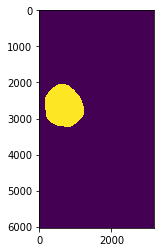

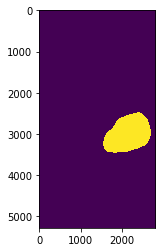

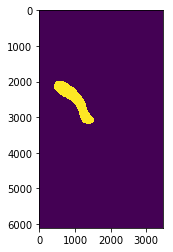

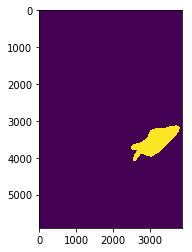

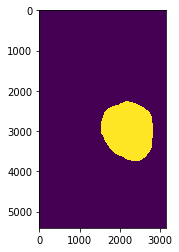

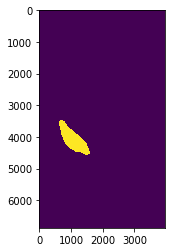

In [46]:
for prob in test_prob:
    row = test_table[test_table[roi_col] == prob].iloc[0]
    roi_image = (grey_loader(path_join(roi_dir_name, mode, str(row['label']), row[roi_col])))
    plt.figure()
    plt.imshow(roi_image)

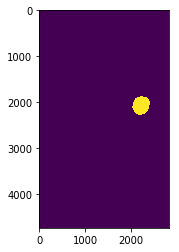

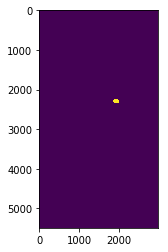

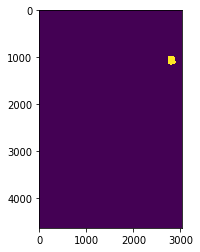

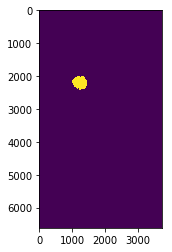

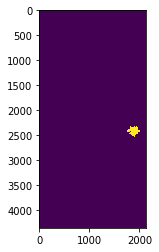

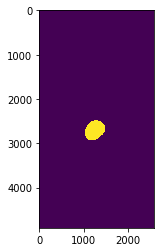

In [44]:
for i in range(len(test_prob)):
    row = test_table.iloc[i]
    roi_image = (grey_loader(path_join(roi_dir_name, mode, str(row['label']), row[roi_col])))
    plt.figure()
    plt.imshow(roi_image)

In [34]:
def get_cont(im):
    _,contours,_ = cv2.findContours(im.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cont_areas = [ cv2.contourArea(cont) for cont in contours ]
    idx = np.argmax(cont_areas)  # find the largest contour.
    rx,ry,rw,rh = cv2.boundingRect(contours[idx])
    return rx,ry,rw,rh

In [35]:
%timeit res = get_cont(roi_f)

4.69 ms ± 89.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
